# Statistical Model
## Approach
In this notebook, we build the statistical model (also called 'OpenBox') used to determine the possible risk increase by certain parameters present in an individual interested in purchasinng a firearm from a dealer.

The idea behind OpenBox is based on Bayesian statistics: we compare the probability of an individual presenting certain conditions knowing they have been involved in a mass shooting to the prevalence of the conditions in the general population. We look at the following conditions:
- mental illness
- employment status
- arrest, charge and conviction
- autism
- age bracket

The risk factor is calculated for each condition in each US state based on publicly-available data. Bayes' Theorem is used to calculate the risk increase:

$ P(S|C) = {P(C|S)*P(S) \over P(C)} =  R*P(S)$, where:
- $ P(S|C) $ is the probability of an individual being a shooter ($S$) knowing that they have condition $C$
- $ P(C|S) $ is the probability of an individual having condition $C$ knowing that they are a shooter ($S$)
- $ P(S) $ is the probability of any individual in the population of being a shooter ($S$)
- $ P(C) $ is the prevalence of condition $C$ in the general population, i.e. the probability of any individual of having the condition

The risk factor $R$ is defined as:

$R = {P(C|S) \over P(C)}$, with:
- $R = 1$ means no risk increase compared to a member of the general population picked at random
- $R > 1$ means more risk compared to any member of the general population
- $R < 1$ means less risk compared to any member of the general population
- The higher $R$ is, the more risk the individual poses

## Data Sources
- **Shooter information**: Peterson, J., & Densley, J. (2023). The Violence Project database of mass shootings in the United States (Version 7). https://www.theviolenceproject.org
- **Mental Illness Information**: States with the highest levels of mental health illness - NiceRx. https://worldpopulationreview.com/state-rankings/mental-health-statistics-by-state
- **Unemployment Data**: Unemployment Rates for States - U.S. Bureau of Labor Statistics (2023). https://worldpopulationreview.com/state-rankings/unemployment-rate-by-state
- **Arrests by State**: Federal Bureau of Investigation (2018). https://ucr.fbi.gov/crime-in-the-u.s/2018/crime-in-the-u.s.-2018/topic-pages/tables/table-69 (Data for Iowa based on 2019 figures due to lack of information in 2018)
- **Autism prevalence**: National Library of Medicine, J Autism Dev Disord. 2020 Dec; 50(12): 4258–4266. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9128411/table/T2/
- **Age and Population**: U.S. Census Bureau (2018-2021). Accessed through `census` Python module API


### Import Dependencies

In [6]:
import pandas as pd
from pathlib import Path
import sys
import matplotlib
import matplotlib.pyplot as plt

# Import SQL Alchemy
from sqlalchemy import create_engine

# Import and establish Base for which classes will be constructed 
import sqlalchemy
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import desc

# Import modules to declare columns and column data types
from sqlalchemy import Column, Integer, String, Float, Boolean

# Ignnore warning
import warnings
warnings.simplefilter(action='ignore')

# Local modules
sys.path.append("../Local_Modules/")
import codebook
from codebook import get_distribution

## Shooter information
Import the data to calculate $P(C|S)$

In [7]:
# Import shooter data
shooters_df = pd.read_csv(Path('../clean_data/clean_shooters.csv'))

shooter_profile = shooters_df[
        [
        'Age',
        'Mental Illness',
        'Employment Status',
        'Highest Level of Justice System Involvement',
        'Autism Spectrum'
        ]]

shooter_profile.head()

,Age,Mental Illness,Employment Status,Highest Level of Justice System Involvement,Autism Spectrum
0,25,1,0,4,0
1,18,2,0,0,0
2,39,4,1,1,0
3,56,0,1,0,0
4,31,2,0,0,0


In [8]:
group_names = [
    'Under 10 years old', '10 to 14 years', '15 to 17 years', '18 and 19 years', '20 years', '21 years', '22 to 24 years', '25 to 29 years',
    '30 to 34 years', '35 to 39 years', '40 to 44 years', '45 to 49 years', '50 to 54 years', '55 to 59 years', '60 and 61 years', '62 to 64 years', '65 and 66 years',
    '67 to 69 years', '70 to 74 years', '75 years and over'
]

bins = [0, 10, 14, 17, 19, 20, 21, 24, 29, 34, 39, 44, 49, 54, 59, 61, 64, 66, 69, 74, 100]

shooter_profile["Age Bracket"] = pd.cut(shooter_profile["Age"], bins, labels = group_names, include_lowest = True)
shooter_profile.head()

,Age,Mental Illness,Employment Status,Highest Level of Justice System Involvement,Autism Spectrum,Age Bracket
0,25,1,0,4,0,25 to 29 years
1,18,2,0,0,0,18 and 19 years
2,39,4,1,1,0,35 to 39 years
3,56,0,1,0,0,55 to 59 years
4,31,2,0,0,0,30 to 34 years


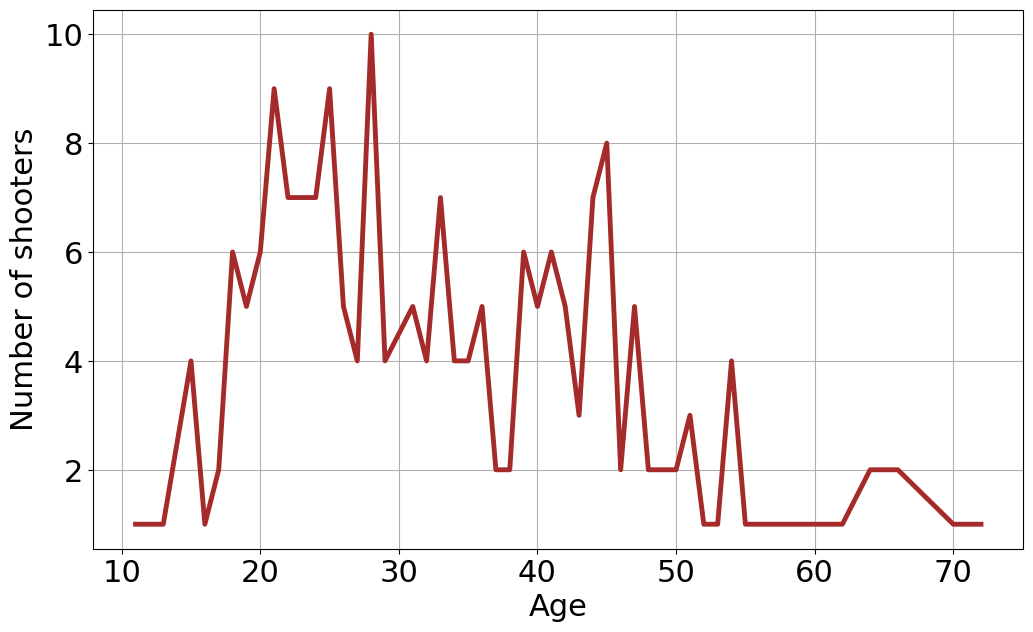

In [9]:
# Change font size
matplotlib.rcParams.update({'font.size': 22})

shooter_profile.groupby('Age').count().sort_index().plot.line(y='Age Bracket', color='#A52A2A', legend=False, figsize=(12,7), linewidth=3.5)
plt.ylabel('Number of shooters')
plt.grid()
plt.show()

In [10]:
print(f"Mean age: {shooter_profile['Age'].mean():.1f} years old")
print(f"Median age: {shooter_profile['Age'].median():.1f} years old")

Mean age: 33.9 years old
Median age: 32.0 years old


### Probability of a shooter having a diagnosed mental illness
Note: shooters with an indication of psychiatric disorder but no diagnosis are assumed to have no mental illness

In [11]:
prob_shooter_with_mental_illness = shooter_profile.loc[(shooter_profile['Mental Illness'] != '0') & (shooter_profile['Mental Illness'] != '4'),'Mental Illness'].count()
prob_shooter_with_mental_illness = 100*prob_shooter_with_mental_illness/len(shooter_profile)
prob_shooter_with_mental_illness

45.07772020725388

### Probability of a shooter being unemployed
Note: only shooters that are surely not working in the dataset are considered 'unemployed'. I.e. when the employment is unknown, it is assumed that the shooter works.

In [12]:
prob_shooter_being_unemployed = shooter_profile.loc[shooter_profile['Employment Status'] == '0','Employment Status'].count()
prob_shooter_being_unemployed = 100*prob_shooter_being_unemployed/len(shooter_profile)
prob_shooter_being_unemployed

54.40414507772021

### Probability of a shooter having been arrested, charged or convicted for a previous crime

In [13]:
# Determine the number of shooters that have been arrested (2), charged (3) or convicted (4)
prob_shooter_being_arrested = shooter_profile.loc[\
    (shooter_profile['Highest Level of Justice System Involvement'] == 2) |\
        (shooter_profile['Highest Level of Justice System Involvement'] == 3) |\
        (shooter_profile['Highest Level of Justice System Involvement'] == 4)\
        ,'Highest Level of Justice System Involvement'].count()

# Divide the number of shooters that have been arrested (2), charged (3) or convicted (4) by the total number of shooters
prob_shooter_being_arrested = 100*prob_shooter_being_arrested/len(shooter_profile)
prob_shooter_being_arrested

52.84974093264249

### Probability of a shooter having autism

In [14]:
prob_shooter_being_autistic = shooter_profile.loc[shooter_profile['Autism Spectrum'] == 1,'Autism Spectrum'].count()
prob_shooter_being_autistic = 100*prob_shooter_being_autistic/len(shooter_profile)
prob_shooter_being_autistic

6.217616580310881

## Conditions in General Population
Import data to calculate $P(C)$

### Mental Illness

In [15]:
# Import mental illness data per state
csv = Path('../raw_data/mental-health-statistics-by-state-[updated-may-2023].csv')
mentalillness_df = pd.read_csv(csv)

# Change state name with 2-letter state code
for key in codebook.codes_states.keys():
    mentalillness_df.loc[mentalillness_df['state']==key,'state'] = codebook.codes_states[key]

# Rename columns and keep only state and mental illness rate columns
mentalillness_df = mentalillness_df.rename(columns={'state': 'State', 'RatesOfMentalIllness':'Mental_Illness_Rate'})
mentalillness_df = mentalillness_df[['State', 'Mental_Illness_Rate']]

In [16]:
mentalillness_df.head()

,State,Mental_Illness_Rate
0,UT,29.68
1,OR,27.33
2,WV,26.05
3,KS,26.02
4,OK,25.59


### Employment Status

In [17]:
# Import unemplyment data
csv = Path('../raw_data/unemployment-rate-by-state-[updated-august-2023].csv')
unemployment_df = pd.read_csv(csv)

# Change state name with 2-letter state code
for key in codebook.codes_states.keys():
    unemployment_df.loc[unemployment_df['state']==key,'state'] = codebook.codes_states[key]

# Keep only 2021 data to be in line with most recent census data
unemployment_df = unemployment_df[['state','unemploymentRateJuly2021']]
    
# Rename columns and keep only state and mental illness rate columns
unemployment_df = unemployment_df.rename(columns={'state': 'State', 'unemploymentRateJuly2021':'Unemployment_Rate'})
unemployment_df = unemployment_df[['State', 'Unemployment_Rate']]

In [18]:
unemployment_df.head()

,State,Unemployment_Rate
0,NV,6.6
1,DC,7.1
2,CA,7.4
3,DE,5.5
4,TX,5.6


### Arrest

In [19]:
# Import arrest data
csv = Path('../raw_data/FBI_2018_crimeByStates.csv')
arrests_df = pd.read_csv(csv)

# Change state name with 2-letter state code
for key in codebook.codes_states.keys():
    arrests_df.loc[arrests_df['State']==key,'State'] = codebook.codes_states[key]

# Delete empty rows
arrests_df = arrests_df.dropna(how='any')

# Recalculate Rate
arrests_df['Rate'] = 100*arrests_df['Arrests']/arrests_df['Population']

# Rename columns and keep only state and mental illness rate columns
arrests_df = arrests_df.rename(columns={'Rate':'Arrest_Rate'})
arrests_df = arrests_df[['State', 'Arrest_Rate']]

arrests_df.head()

,State,Arrest_Rate
0,AL,2.586075
1,AK,4.152213
2,AZ,3.580559
3,AR,3.989615
4,CA,2.763300


### Autism

In [20]:
# Import Autism Data
csv = Path('../clean_data/clean_autism.csv')
autism_df = pd.read_csv(csv)

# Keep only State and Prevalence column (rename)
autism_df = autism_df.rename(columns={'Prevalence':'Autism_Rate'})
autism_df = autism_df[['State', 'Autism_Rate']]


In [21]:
autism_df.head()

,State,Autism_Rate
0,AL,2.12
1,AK,2.19
2,AZ,2.29
3,AR,2.03
4,CA,2.36


### Merge State Information dataframes

In [22]:
state_info_df = pd.merge(mentalillness_df, unemployment_df, how='outer', on='State')
state_info_df = pd.merge(state_info_df, arrests_df, how='outer', on='State')
state_info_df = pd.merge(state_info_df, autism_df, how='outer', on='State')


state_info_df.head()

,State,Mental_Illness_Rate,Unemployment_Rate,Arrest_Rate,Autism_Rate
0,UT,29.68,2.7,3.318017,2.28
1,OR,27.33,5.1,2.988274,2.28
2,WV,26.05,5.1,1.617094,2.07
3,KS,26.02,3.4,1.127836,2.19
4,OK,25.59,3.9,2.562794,2.13


## Risk Factor Table

In [23]:
state_risks_df = state_info_df[:]

# Rename columns
state_risks_df = state_risks_df.rename(columns={
    'Mental_Illness_Rate': 'Mental_Illness_Risk',
    'Unemployment_Rate': 'Unemployment_Risk',
    'Arrest_Rate': 'Arrest_Risk',
    'Autism_Rate': 'Autism_Risk',
})

# Calculate risk factors
state_risks_df['Mental_Illness_Risk'] = prob_shooter_with_mental_illness/state_info_df['Mental_Illness_Rate']
state_risks_df['Unemployment_Risk'] =  prob_shooter_being_unemployed/state_info_df['Unemployment_Rate']
state_risks_df['Arrest_Risk'] =  prob_shooter_being_arrested/state_info_df['Arrest_Rate']
state_risks_df['Autism_Risk'] =  prob_shooter_being_autistic/state_info_df['Autism_Rate']

# Replace NaN by 1 (no risk increase)
state_risks_df = state_risks_df.fillna(1)

# Display Risk Factor for OpenBox
state_risks_df.head(3)

,State,Mental_Illness_Risk,Unemployment_Risk,Arrest_Risk,Autism_Risk
0,UT,1.518791,20.149683,15.928111,2.727025
1,OR,1.649386,10.667479,17.685706,2.727025
2,WV,1.730431,10.667479,32.681924,3.003680


## Age-based Risk Factor

In [24]:
# Shooter age distribution
age_stat_df = get_distribution(shooter_profile, 'Age Bracket',0)
age_stat_df

,Age Bracket,Percent
25 to 29 years,32,16.580311
40 to 44 years,26,13.471503
22 to 24 years,21,10.880829
30 to 34 years,20,10.362694
35 to 39 years,19,9.844560
45 to 49 years,17,8.808290
18 and 19 years,11,5.699482
50 to 54 years,11,5.699482
21 years,9,4.663212
15 to 17 years,7,3.626943


### Functions

In [25]:
def get_state_age_distribution(male_age_census_pd, state):
    # Filter data based on state
    state_data_percent = male_age_census_pd.loc[male_age_census_pd['state']==state,:]

    # Reset and delete index column
    state_data_percent = state_data_percent.reset_index()
    state_data_percent = state_data_percent.drop(columns='index')

    # Calculate Percent of population in each age bracket
    for b in group_names:
        state_data_percent.loc[0,b] = 100*state_data_percent.loc[0,b]/state_data_percent.loc[0,'Total Population']

    # Drop ununsed columns
    state_data_percent = state_data_percent.drop(columns=['state','Total Population'])

    # Transpose DataFrame
    state_data_percent = state_data_percent.transpose()

    # Rename state column
    state_data_percent = state_data_percent.rename(columns={0: state})

    # Return DataFrame for state
    return state_data_percent

def get_age_risk_factor_table(stat_df, male_age_census_pd, state):
    # Filter census data by state
    state_data_percent = get_state_age_distribution(male_age_census_pd, state).reset_index()
    stat_df_w_index = stat_df.reset_index()

    # Merge census data and shooter dataframes
    age_risk_factor = pd.merge(state_data_percent, stat_df_w_index, how='outer', on='index')
    age_risk_factor = age_risk_factor.drop(columns=['Age Bracket'])

    # Add new column with Risk
    age_risk_factor['Risk'] = age_risk_factor['Percent']/age_risk_factor[state]

    # Drop unnecessary columns
    age_risk_factor = age_risk_factor.drop(columns=[state, 'Percent'])

    # Rename columns
    age_risk_factor = age_risk_factor.rename(columns={'Risk': state})

    # Get column names
    column_names = age_risk_factor['index'].tolist()

    # Transpose DataFrame
    age_risk_factor_t = age_risk_factor.transpose()

    # Rename columns to age brackets
    for i in range(len(column_names)):
        age_risk_factor_t = age_risk_factor_t.rename(columns={i: column_names[i]})

    # Drop first row
    age_risk_factor_t = age_risk_factor_t.iloc[1:]

    # Return risk factor DataFrame
    return age_risk_factor_t

### Get census data

In [26]:
# Get census data (saved file)
csv = Path('../clean_data/clean_male_population_age.csv')
male_age_census_pd = pd.read_csv(csv)

# Get all states available in census data
states = male_age_census_pd['state'].tolist()

# Create age risk table for first state in list
state = states[0]
age_risk_factor = get_age_risk_factor_table(age_stat_df, male_age_census_pd, state)

# Create and join age risk tables for all other states
for state in states[1:]:
    age_risk_factor = pd.concat([age_risk_factor, get_age_risk_factor_table(age_stat_df, male_age_census_pd, state)])

age_risk_factor = age_risk_factor.reset_index()
age_risk_factor = age_risk_factor.rename(columns={'index': 'State'})

age_risk_factor.head()

,State,Under 10 years old,10 to 14 years,15 to 17 years,18 and 19 years,20 years,21 years,22 to 24 years,25 to 29 years,30 to 34 years,...,40 to 44 years,45 to 49 years,50 to 54 years,55 to 59 years,60 and 61 years,62 to 64 years,65 and 66 years,67 to 69 years,70 to 74 years,75 years and over
0,AL,0.0,0.150196,0.881469,2.055796,2.050626,3.396858,2.829715,2.439607,1.634751,...,2.186796,1.397295,0.883161,0.306953,0.193257,0.398008,0.44048,0.0,0.237712,0.0
1,AK,0.0,0.156446,0.931737,2.219953,2.07947,2.817915,2.465191,2.015245,1.333145,...,2.243301,1.474367,0.934926,0.324796,0.189516,0.442545,0.454467,0.0,0.322602,0.0
2,AZ,0.0,0.149564,0.889863,2.029909,2.142186,3.323177,2.611481,2.283494,1.507185,...,2.171906,1.467991,0.969109,0.346219,0.213345,0.464922,0.480466,0.0,0.22793,0.0
3,AR,0.0,0.146305,0.861799,2.024784,1.965137,3.385519,2.824682,2.483564,1.613212,...,2.192086,1.444728,0.931764,0.314244,0.202168,0.441608,0.456858,0.0,0.245823,0.0
4,CA,0.0,0.149982,0.902097,2.120133,2.19396,3.405815,2.679191,2.125191,1.345713,...,2.048777,1.363897,0.888911,0.329558,0.211597,0.4761,0.524872,0.0,0.299038,0.0


## Merge all risks factors

In [27]:
state_risks_df = pd.merge(state_risks_df, age_risk_factor, how='left', on='State')
state_risks_df.head(3)

,State,Mental_Illness_Risk,Unemployment_Risk,Arrest_Risk,Autism_Risk,Under 10 years old,10 to 14 years,15 to 17 years,18 and 19 years,20 years,...,40 to 44 years,45 to 49 years,50 to 54 years,55 to 59 years,60 and 61 years,62 to 64 years,65 and 66 years,67 to 69 years,70 to 74 years,75 years and over
0,UT,1.518791,20.149683,15.928111,2.727025,0.0,0.12032,0.714863,1.87925,2.015117,...,2.038276,1.550392,1.17236,0.437149,0.265069,0.591181,0.644525,0.0,0.374887,0.0
1,OR,1.649386,10.667479,17.685706,2.727025,0.0,0.165051,0.97738,2.311804,2.425529,...,1.993524,1.377162,0.929444,0.331264,0.203853,0.40842,0.404722,0.0,0.225945,0.0
2,WV,1.730431,10.667479,32.681924,3.003680,0.0,0.165641,0.977214,2.109745,2.317901,...,2.190507,1.363896,0.860544,0.300732,0.181657,0.358506,0.372892,0.0,0.203541,0.0


### Interpolate data for risk-0 in 67 to 69 years age bracket
A value of 0 would drop the overall risk to 0, which may not be conservative enough. Instead, we interpolate the value for this bracket based on the average of the brackets to the left and right of it.

In [28]:
# Calculate risk based on adjacent brackets
state_risks_df['67 to 69 years'] = (state_risks_df['65 and 66 years']+state_risks_df['70 to 74 years'])/2

### Extrapolate data for risk-0 in 75 years and over age bracket
A value of 0 would drop the overall risk to 0, which may not be conservative enough. Instead, we extrapolate the value by extending the value of risk for the '70 to 74 years' age bracket to the last age bracket. Nothing is done for the age bracket of 10 years and younger as it is assumed that a firearm cannot be bought by an individual that young and should not be allowed.

In [29]:
# Calculate risk based on previous bracket
state_risks_df['75 years and over'] = state_risks_df['70 to 74 years']

## Save data to SQL

In [33]:
# Get Base
Base = declarative_base()

# Create RiskMatrix class
class RiskMatrix(Base):
    __tablename__ = 'riskmatrix'
    risk_id = Column(Integer, primary_key=True)
    state = Column(String)
    mental_illness = Column(Float)
    unemployment = Column(Float)
    arrest = Column(Float)
    autism = Column(Float)
    age_Under_10 = Column(Float)
    age_10_to_14 = Column(Float)
    age_15_to_17 = Column(Float)
    age_18_and_19 = Column(Float)
    age_20 = Column(Float)
    age_21 = Column(Float)
    age_22_to_24 = Column(Float)
    age_25_to_29 = Column(Float)
    age_30_to_34 = Column(Float)
    age_35_to_39 = Column(Float)
    age_40_to_44 = Column(Float)
    age_45_to_49 = Column(Float)
    age_50_to_54 = Column(Float)
    age_55_to_59 = Column(Float)
    age_60_and_61 = Column(Float)
    age_62_to_64 = Column(Float)
    age_65_and_66 = Column(Float)
    age_67_to_69 = Column(Float)
    age_70_to_74 = Column(Float)
    age_75_over = Column(Float)

# Create a connection to a SQLite database
engine = create_engine('sqlite:///./openbox_db.sqlite')

# Create the tables within the database
Base.metadata.create_all(engine)

# Start session
session = Session(bind=engine)

In [35]:
# Loop through risk DataFrame and retrieve data
for index, row in state_risks_df.iterrows():
    # Add data to database
    session.add(RiskMatrix(
        state = state_risks_df.loc[index,'State'],
        mental_illness = state_risks_df.loc[index,'Mental_Illness_Risk'],
        unemployment = state_risks_df.loc[index,'Unemployment_Risk'],
        arrest = state_risks_df.loc[index,'Arrest_Risk'],
        autism = state_risks_df.loc[index,'Autism_Risk'],
        age_Under_10 = state_risks_df.loc[index,'Under 10 years old'],
        age_10_to_14 = state_risks_df.loc[index,'10 to 14 years'],
        age_15_to_17 = state_risks_df.loc[index,'15 to 17 years'],
        age_18_and_19 = state_risks_df.loc[index,'18 and 19 years'],
        age_20 = state_risks_df.loc[index,'20 years'],
        age_21 = state_risks_df.loc[index,'21 years'],
        age_22_to_24 = state_risks_df.loc[index,'22 to 24 years'],
        age_25_to_29 = state_risks_df.loc[index,'25 to 29 years'],
        age_30_to_34 = state_risks_df.loc[index,'30 to 34 years'],
        age_35_to_39 = state_risks_df.loc[index,'35 to 39 years'],
        age_40_to_44 = state_risks_df.loc[index,'40 to 44 years'],
        age_45_to_49 = state_risks_df.loc[index,'45 to 49 years'],
        age_50_to_54 = state_risks_df.loc[index,'50 to 54 years'],
        age_55_to_59 = state_risks_df.loc[index,'55 to 59 years'],
        age_60_and_61 = state_risks_df.loc[index,'60 and 61 years'],
        age_62_to_64 = state_risks_df.loc[index,'62 to 64 years'],
        age_65_and_66 = state_risks_df.loc[index,'65 and 66 years'],
        age_67_to_69 = state_risks_df.loc[index,'67 to 69 years'],
        age_70_to_74 = state_risks_df.loc[index,'70 to 74 years'],
        age_75_over = state_risks_df.loc[index,'75 years and over'] 
    ))

print(f"{len(state_risks_df)} rows ready for commit.")

51 rows ready for commit.


In [36]:
# Commit changes to session
session.commit()

In [37]:
# Close session
session.close()